# WeakAlign demo notebook

This notebook shows how to run a trained model on a given image pair

## Imports

In [1]:
from __future__ import print_function, division
import os
from os.path import exists
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric, TwoStageCNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_pascal
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict
import torch.nn.functional as F

warnings.filterwarnings('ignore')

In [2]:
from __future__ import print_function
from PIL import Image
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from model.loss import TransformedGridLoss, WeakInlierCount, TwoStageWeakInlierCount

## Parameters

In [4]:
# Select one of the following models:
# cnngeo_vgg16, cnngeo_resnet101, proposed_resnet101
model_selection = 'proposed_resnet101' 

model_aff_path = ''
model_tps_path = ''
model_aff_tps_path = ''

if model_selection=='cnngeo_vgg16':
    model_aff_path = 'trained_models/trained_models/cnngeo_vgg16_affine.pth.tar'
    model_tps_path = 'trained_models/trained_models/cnngeo_vgg16_tps.pth.tar'
    feature_extraction_cnn = 'vgg'
    
elif model_selection=='cnngeo_resnet101':
    model_aff_path = 'trained_models/trained_models/cnngeo_resnet101_affine.pth.tar'
    model_tps_path = 'trained_models/trained_models/cnngeo_resnet101_tps.pth.tar'   
    feature_extraction_cnn = 'resnet101'
    
elif model_selection=='proposed_resnet101':
    model_aff_tps_path = 'trained_models/weakalign_resnet101_affine_tps.pth.tar'
    feature_extraction_cnn = 'resnet101'
    

# source_image_path='datasets/proposal-flow-pascal/PF-dataset-PASCAL/JPEGImages/2008_006325.jpg'
# target_image_path='datasets/proposal-flow-pascal/PF-dataset-PASCAL/JPEGImages/2010_004954.jpg'
# source_image_path='datasets/1.jpg'
# target_image_path='datasets/2.jpg'
# source_image_path='datasets/3.JPEG'
# target_image_path='datasets/4.JPEG'

flowers = ['datasets/1.jpg', 'datasets/2.jpg']
dogs = ['datasets/3.JPEG', 'datasets/4.JPEG']
armours = ['datasets/5.JPEG', 'datasets/6.JPEG']
# if not exists(source_image_path):
#     download_PF_pascal('datasets/proposal-flow-pascal/')

In [5]:
source_image_path = dogs[0]
target_image_path = flowers[1]

## Load models

In [6]:
use_cuda = torch.cuda.is_available()

model = TwoStageCNNGeometric(use_cuda=use_cuda,
                             return_correlation=True,
                             feature_extraction_cnn=feature_extraction_cnn)

# load pre-trained model
if model_aff_tps_path!='':
    checkpoint = torch.load(model_aff_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
        
    for name, param in model.FeatureExtraction.state_dict().items():
        model.FeatureExtraction.state_dict()[name].copy_(checkpoint['state_dict']['FeatureExtraction.' + name])    
    for name, param in model.FeatureRegression.state_dict().items():
        model.FeatureRegression.state_dict()[name].copy_(checkpoint['state_dict']['FeatureRegression.' + name])
    for name, param in model.FeatureRegression2.state_dict().items():
        model.FeatureRegression2.state_dict()[name].copy_(checkpoint['state_dict']['FeatureRegression2.' + name])    
else:
    checkpoint_aff = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint_aff['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint_aff['state_dict'].items()])
    for name, param in model.FeatureExtraction.state_dict().items():
        model.FeatureExtraction.state_dict()[name].copy_(checkpoint_aff['state_dict']['FeatureExtraction.' + name])    
    for name, param in model.FeatureRegression.state_dict().items():
        model.FeatureRegression.state_dict()[name].copy_(checkpoint_aff['state_dict']['FeatureRegression.' + name])

    checkpoint_tps = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint_tps['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint_tps['state_dict'].items()])
    for name, param in model.FeatureRegression2.state_dict().items():
        model.FeatureRegression2.state_dict()[name].copy_(checkpoint_tps['state_dict']['FeatureRegression.' + name])

## Create image transformers

In [7]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)

## Load and preprocess images

In [8]:
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [10]:
n_epochs = 20
n_episodes = 100
n_way = 20
n_shot = 5
n_query = 5
n_examples = 20
im_width, im_height, channels = 28, 28, 1
h_dim = 64
z_dim = 64

In [35]:
# Load Train Dataset
data_generator_path = os.environ['DATA_GENERATOR']
train_split_path = os.path.join(data_generator_path, 'labels/omniglot', 'train.txt')
with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]
n_classes = len(train_classes)
train_dataset = np.zeros([n_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(train_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(data_generator_path, 'datasets/omniglot', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        train_dataset[i, j] = im
print(train_dataset.shape)

(4112, 20, 28, 28)


In [36]:
char1_1 = train_dataset[10][0]
char1_2 = train_dataset[10][1]

char2_1 = train_dataset[1][0]
char2_2 = train_dataset[1][1]

In [50]:
source_img = char1_1
target_img = char2_2

source_image = np.stack((source_img,)*3, axis=-1)
target_image = np.stack((target_img,)*3, axis=-1)

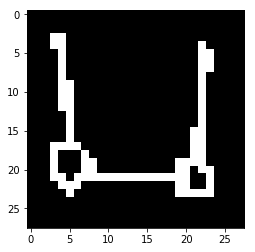

In [51]:
plt.imshow(source_image)

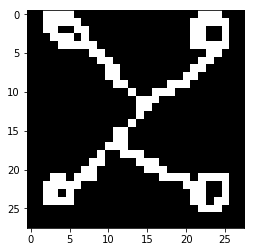

In [52]:
plt.imshow(target_image)

In [53]:
# source_image = io.imread(source_image_path)
# target_image = io.imread(target_image_path)

# source_image_var = preprocess_image(source_image)
# target_image_var = preprocess_image(target_image)

# if use_cuda:
#     source_image_var = source_image_var.cuda()
#     target_image_var = target_image_var.cuda()

# batch = {'source_image': source_image_var, 'target_image':target_image_var}

# resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

In [54]:
source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)

if use_cuda:
    source_image_var = source_image_var.cuda()
    target_image_var = target_image_var.cuda()

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

## Evaluate model

In [55]:
model.eval()

# Evaluate model
#theta_aff,theta_aff_tps=model(batch)
theta_aff,theta_aff_tps,corr_aff,corr_aff_tps=model(batch)

In [56]:
print("theta_aff : {}, theta_aff_tps : {}".format(theta_aff.data, theta_aff_tps.data))

theta_aff : 
 0.9695 -0.1475  0.0845  0.1470  0.9551  0.1584
[torch.cuda.FloatTensor of size 1x6 (GPU 0)]
, theta_aff_tps : 

Columns 0 to 9 
-1.0751 -1.1727 -1.0163  0.0118  0.1736 -0.0027  0.9296  0.9355  0.9383 -1.1194

Columns 10 to 17 
-0.0667  0.7627 -1.2566  0.1773  0.9347 -0.9542 -0.1518  0.9336
[torch.cuda.FloatTensor of size 1x18 (GPU 0)]



In [57]:
arg_groups = {'tps_grid_size': 3, 'tps_reg_factor': 0.2, 'normalize_inlier_count': True, 'dilation_filter': 0, 'use_conv_filter': False}

In [58]:
inliersAffine = WeakInlierCount(geometric_model='affine',**arg_groups)
#inliersTps = WeakInlierCount(geometric_model='tps',**arg_groups['weak_loss'])
inliersComposed = TwoStageWeakInlierCount(use_cuda=use_cuda,**arg_groups)

In [59]:
inliers_comp = inliersComposed(matches=corr_aff,
                                                 theta_aff=theta_aff,
                                                 theta_aff_tps=theta_aff_tps)

In [60]:
inliers_aff = inliersAffine(matches=corr_aff,
                                theta=theta_aff)

## Compute warped images

In [61]:
def affTpsTnf(source_image, theta_aff, theta_aff_tps, use_cuda=use_cuda):
    tpstnf = GeometricTnf(geometric_model = 'tps',use_cuda=use_cuda)
    sampling_grid = tpstnf(image_batch=source_image,
                           theta_batch=theta_aff_tps,
                           return_sampling_grid=True)[1]
    X = sampling_grid[:,:,:,0].unsqueeze(3)
    Y = sampling_grid[:,:,:,1].unsqueeze(3)
    Xp = X*theta_aff[:,0].unsqueeze(1).unsqueeze(2)+Y*theta_aff[:,1].unsqueeze(1).unsqueeze(2)+theta_aff[:,2].unsqueeze(1).unsqueeze(2)
    Yp = X*theta_aff[:,3].unsqueeze(1).unsqueeze(2)+Y*theta_aff[:,4].unsqueeze(1).unsqueeze(2)+theta_aff[:,5].unsqueeze(1).unsqueeze(2)
    sg = torch.cat((Xp,Yp),3)
    warped_image_batch = F.grid_sample(source_image, sg)

    return warped_image_batch

warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))
warped_image_aff_tps = affTpsTnf(batch['source_image'],theta_aff,theta_aff_tps)

## Display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


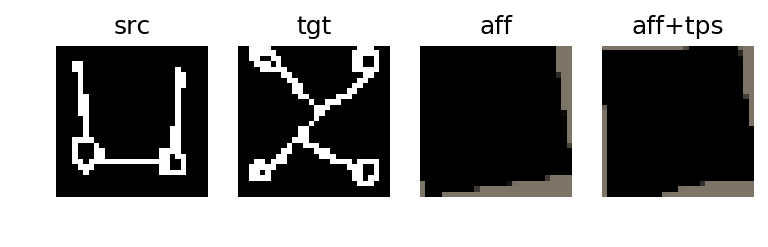

In [62]:
# Un-normalize images and convert to numpy
warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

N_subplots = 4
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('src')
axs[1].imshow(target_image)
axs[1].set_title('tgt')
axs[2].imshow(warped_image_aff_np)
axs[2].set_title('aff')
axs[3].imshow(warped_image_aff_tps_np)
axs[3].set_title('aff+tps')

for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(150)
plt.show()

In [63]:
print("inliers_aff : {} \n inliers_comp : {} \n total {}: ".format(inliers_aff.data, 
                                                                 inliers_comp.data, 
                                                                 inliers_aff.data+inliers_comp.data))

inliers_aff : 
1.00000e-02 *
  7.7623
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 inliers_comp : 
1.00000e-02 *
  7.9386
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 total 
 0.1570
[torch.cuda.FloatTensor of size 1 (GPU 0)]
: 
